In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
import os
from scipy.signal import find_peaks
import matplotlib.colors as mcolors
import seaborn as sns  # 用于绘制热图

In [5]:

# -------------------------- 字体设置与自动检测 --------------------------
def setup_chinese_font():
    """自动检测并设置可用的中文字体"""
    # 常见的中文字体列表
    chinese_fonts = [
        'SimHei', 'Microsoft YaHei', 'KaiTi', 'FangSong',
        'SimSun', 'NSimSun', 'SimHei', 'YouYuan',
        'WenQuanYi Micro Hei', 'WenQuanYi Zen Hei', 'AR PL UMing CN',
        'Noto Sans CJK SC', 'Noto Sans CJK TC', 'Source Han Sans SC',
        'DejaVu Sans', 'Arial Unicode MS'  # 后备字体
    ]

    # 检测系统中可用的字体
    available_fonts = set(f.name for f in fm.fontManager.ttflist)

    # 选择第一个可用的中文字体
    for font in chinese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            print(f"使用字体: {font}")
            break
    else:
        # 如果没有找到中文字体，使用默认字体并提示
        print("警告: 未找到中文字体，使用系统默认字体")

    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题




In [6]:
# -------------------------- 1. 数据读取与预处理 --------------------------
def read_data(file_path):
    """读取CSV文件并自动处理编码问题"""
    encodings = ['utf-8', 'gbk', 'gb2312', 'gb18030', 'latin-1']

    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, index_col=0, encoding=encoding)
            print(f"成功读取文件，使用编码: {encoding}")
            print(f"数据形状：{df.shape}（样本数×特征数）")
            return df
        except UnicodeDecodeError:
            continue
        except Exception as e:
            print(f"使用编码{encoding}读取失败: {str(e)}")

    raise ValueError("无法解析文件，请检查文件格式和编码")


# 读取数据
file_path = r'D:\AI_for_electrolyte\S\Input_feature2.csv'  # 替换为你的文件路径
df = read_data(file_path)

# 处理缺失值
if df.isnull().any().any():
    missing_ratio = df.isnull().sum().sum() / (df.shape[0] * df.shape[1])
    print(f"检测到缺失值，占比: {missing_ratio:.2%}，使用特征均值填充")
    df = df.fillna(df.mean())

# 数据标准化
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df),
    index=df.index,
    columns=df.columns
)


成功读取文件，使用编码: gbk
数据形状：(4436, 44)（样本数×特征数）


In [7]:
# -------------------------- 2. 分层聚类计算 --------------------------
print("开始分层聚类计算...")
start_time = time.time()

# 计算距离矩阵（使用余弦距离适合高维数据）
distance_matrix = pdist(df_scaled, metric='cosine')

# 构建层次聚类树（使用ward方法）
linkage_matrix = linkage(distance_matrix, method='ward')

end_time = time.time()
print(f"分层聚类计算完成，耗时: {end_time - start_time:.2f}秒")

开始分层聚类计算...
分层聚类计算完成，耗时: 0.54秒


In [9]:
# -------------------------- 3. 自动确定有意义的聚类层次 --------------------------
print("根据数据特征自动确定聚类层次...")

# 提取合并高度（反映聚类距离）
merge_heights = linkage_matrix[:, 2]

# 计算合并高度的一阶差分（变化率）
height_diff = np.diff(merge_heights)

# 找到差分中的峰值（这些点表示聚类结构发生显著变化）
# 峰值越高，表示该点的聚类合并距离变化越大，是自然的分割点
peaks, _ = find_peaks(height_diff, height=np.percentile(height_diff, 75), distance=10)

# 确保至少有几个聚类层次
if len(peaks) < 3:
    # 如果峰值太少，使用分位数方法补充
    percentiles = np.linspace(95, 5, 5)  # 5个分位
    additional_points = [np.percentile(merge_heights, p) for p in percentiles]
    # 转换为索引
    additional_indices = [np.argmin(np.abs(merge_heights - p)) for p in additional_points]
    peaks = np.unique(np.concatenate([peaks, additional_indices]))

# 对峰值排序并选择最有意义的8-12个层次（根据数据自动调整）
peaks = np.sort(peaks)
n_layers = min(max(len(peaks), 8), 12)  # 确保8-12个层次
selected_peaks = peaks[-n_layers:]  # 选择最显著的峰值

# 计算每个选中层次对应的聚类数
n_samples = df.shape[0]
cluster_counts = [n_samples - (peak + 1) for peak in selected_peaks]
# 确保聚类数唯一且递减
cluster_counts = sorted(list(set(cluster_counts)), reverse=True)
# 确保最终有合理数量的层次
if len(cluster_counts) < 5:
    cluster_counts = sorted([n_samples - int(n_samples * f) for f in np.linspace(0.1, 0.9, 10)], reverse=True)

print(f"根据数据特征自动确定了 {len(cluster_counts)} 个聚类层次")
print(f"各层次聚类数: {', '.join(map(str, cluster_counts))}")

根据数据特征自动确定聚类层次...
根据数据特征自动确定了 12 个聚类层次
各层次聚类数: 153, 140, 125, 115, 105, 87, 77, 65, 55, 33, 20, 4


In [10]:
# -------------------------- 4. 提取自适应聚类结果 --------------------------
print("提取各层聚类结果...")
start_time = time.time()

results = []
for i, n_clusters in enumerate(cluster_counts):
    # 获取当前聚类数对应的标签
    labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    # 保存结果
    results.append(pd.DataFrame({
        '样本ID': df.index,
        f'第{i + 1}层(聚类数={n_clusters})': labels
    }).set_index('样本ID'))

# 合并结果并保存
all_layers = pd.concat(results, axis=1)
output_dir = ("20250925")
os.makedirs(output_dir, exist_ok=True)
excel_path = os.path.join(output_dir, "自适应聚类各层结果4.xlsx")
all_layers.to_excel(excel_path, engine='openpyxl')

end_time = time.time()
print(f"聚类结果已保存至: {excel_path}")
print(f"提取完成，耗时: {end_time - start_time:.2f}秒")

提取各层聚类结果...
聚类结果已保存至: 20250925\自适应聚类各层结果4.xlsx
提取完成，耗时: 1.49秒


绘制每个簇只显示一个名称的树状图（第四层）...
第四层聚类数: 115


C:\Users\zhang yanan\AppData\Local\Temp\ipykernel_21560\2408453049.py:85: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


树状图已保存至: 20250925\第四层每个簇只显示一个名称的树状图.png


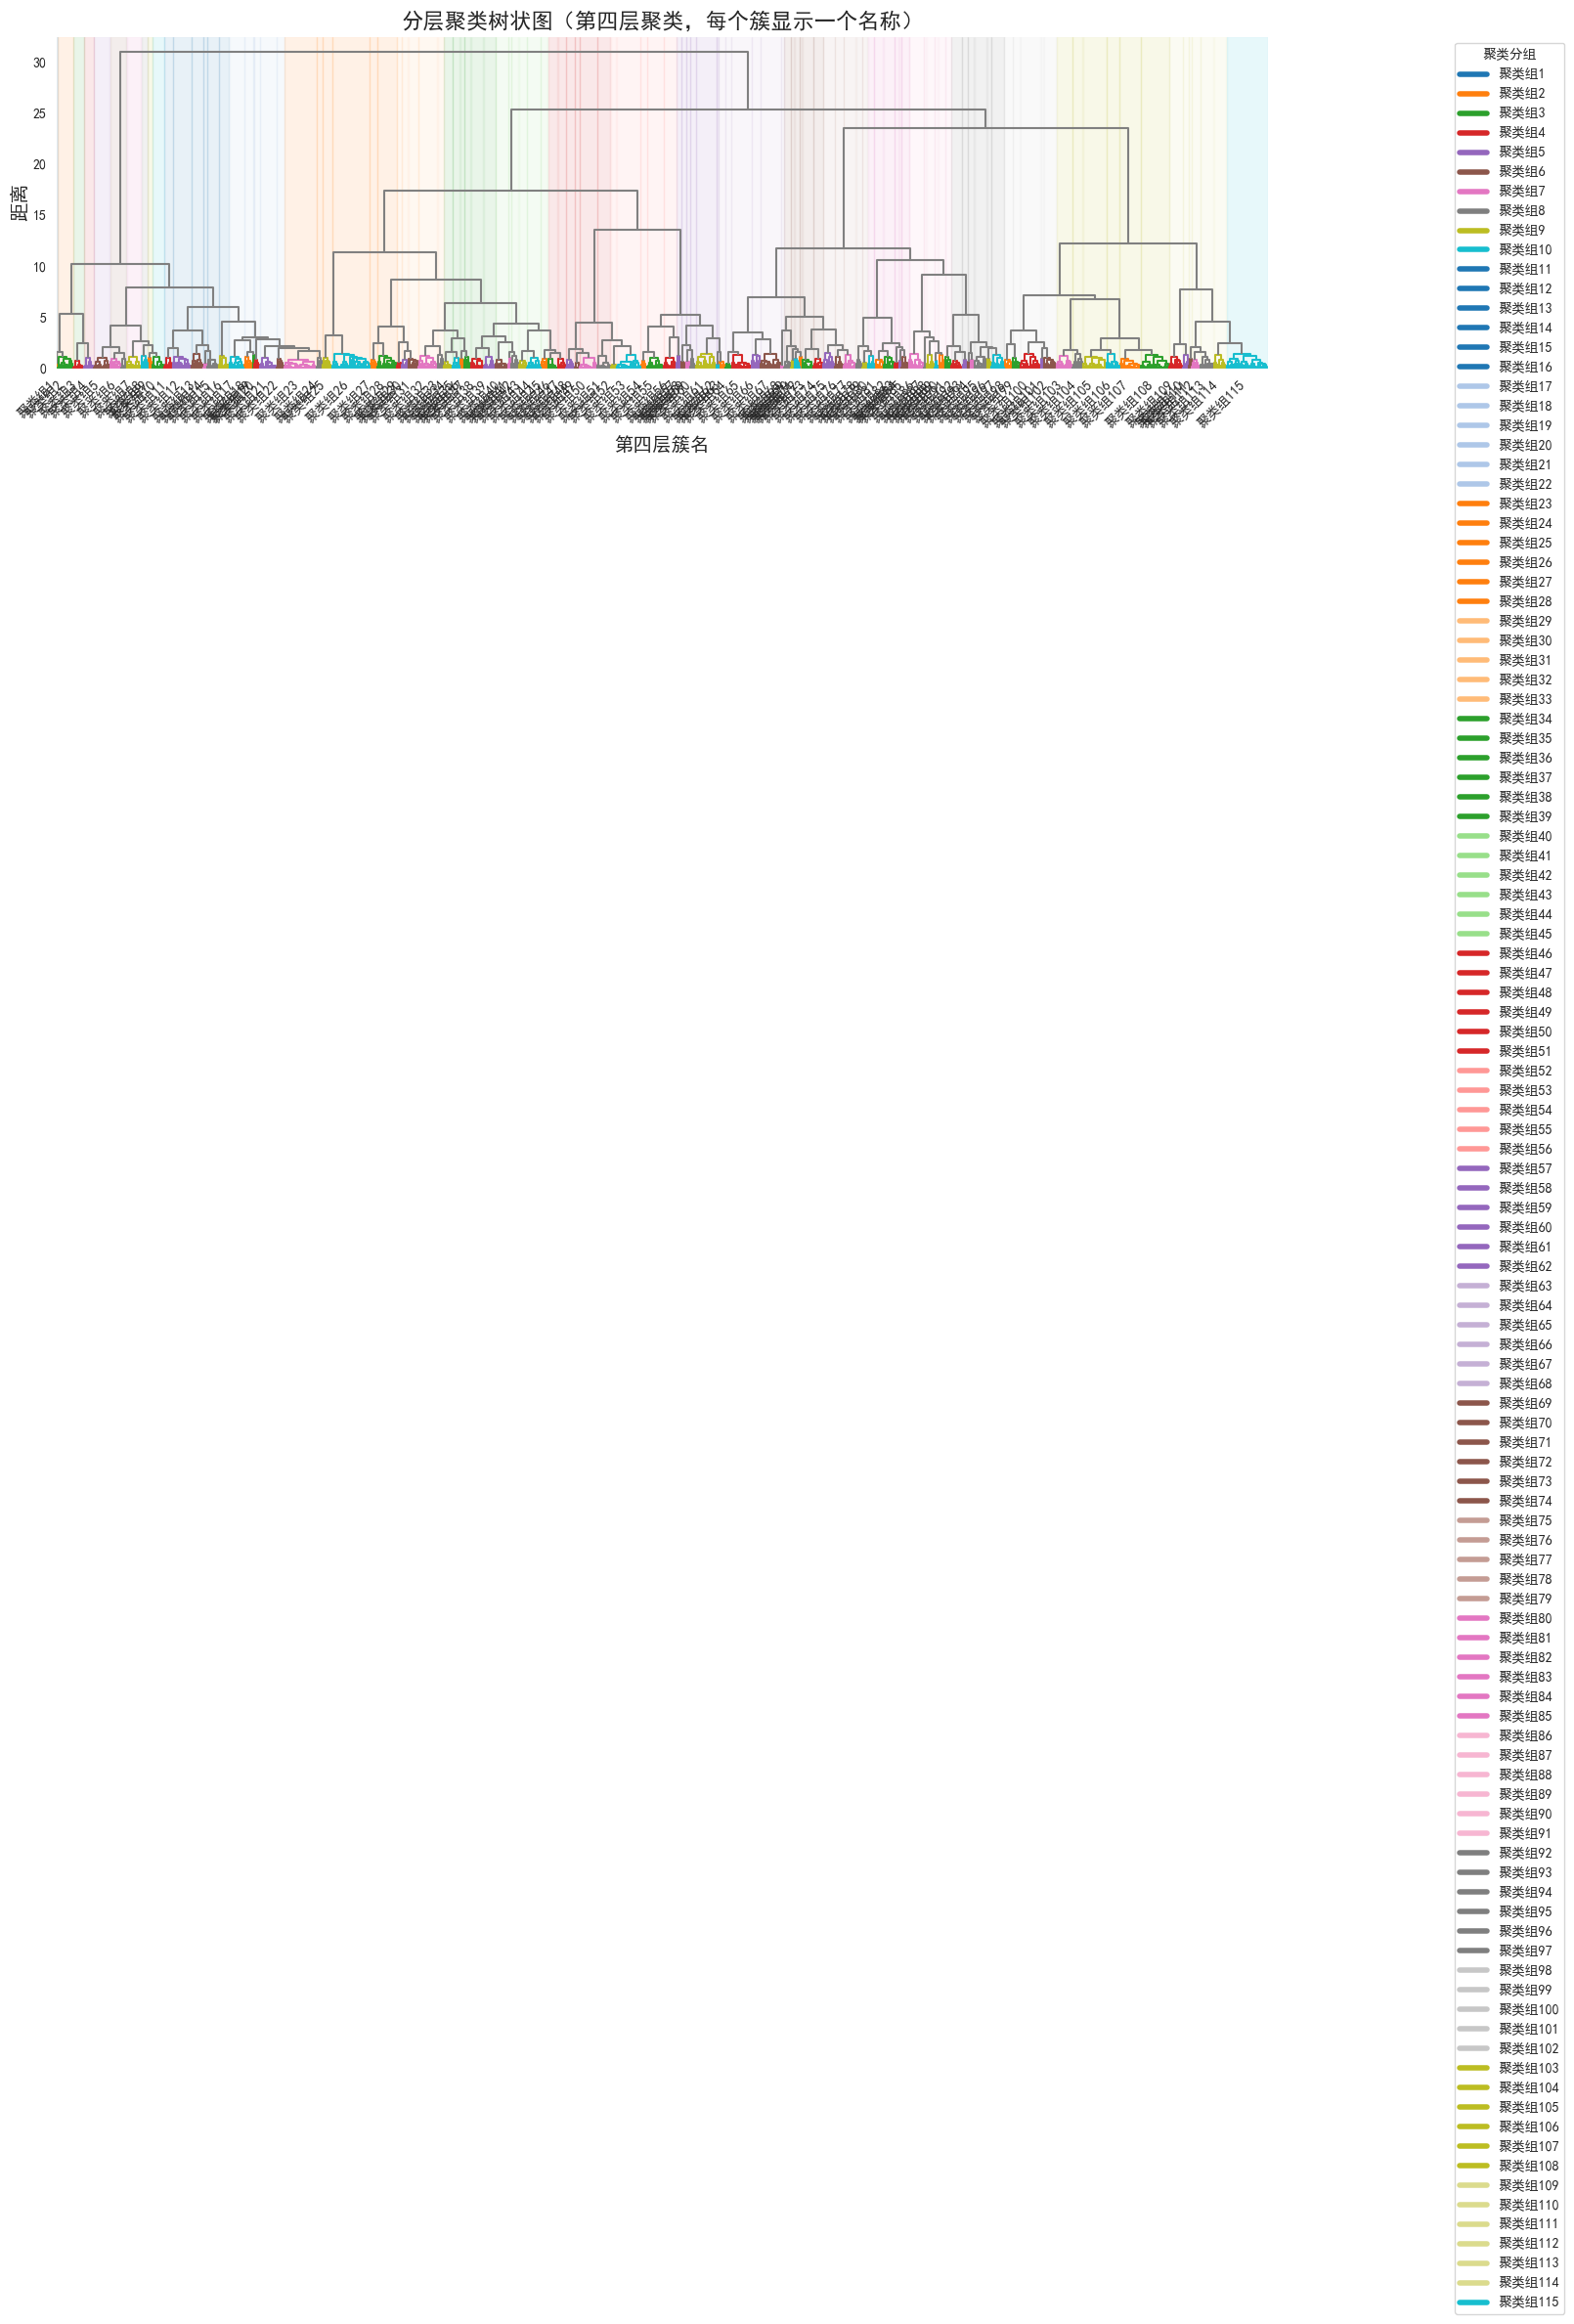

In [23]:
print("绘制每个簇只显示一个名称的树状图（第四层）...")

# 确保有至少4层聚类
if len(cluster_counts) >= 4:
    # 获取第四层的聚类数和标签（修改为第四层）
    fourth_layer_cluster_count = cluster_counts[3]
    fourth_layer_labels = fcluster(linkage_matrix, t=fourth_layer_cluster_count, criterion='maxclust')
    print(f"第四层聚类数: {fourth_layer_cluster_count}")

    # 生成足够的颜色和对应的簇名
    num_clusters = len(np.unique(fourth_layer_labels))
    colors = list(mcolors.TABLEAU_COLORS.values())
    if num_clusters > len(colors):
        colors += [mcolors.to_hex(plt.cm.tab20(i/num_clusters)) for i in range(num_clusters - len(colors))]

    # 创建簇ID到簇名的映射（如1→"聚类组1"）
    cluster_ids = sorted(np.unique(fourth_layer_labels))
    cluster_id_to_name = {cid: f"聚类组{cid}" for cid in cluster_ids}

    # 创建画布
    plt.figure(figsize=(16, 5))

    # 绘制树状图并获取叶子位置信息
    dendro_info = dendrogram(
        linkage_matrix,
        # 不显示原始样本标签
        labels=[''] * len(df.index),
        color_threshold=merge_heights[-(fourth_layer_cluster_count + 1)],  # 使用第四层的阈值
        above_threshold_color='gray',
        show_contracted=True,
        no_plot=False
    )

    # 获取叶子在x轴上的位置
    leaf_positions = dendro_info['leaves']
    ax = plt.gca()
    x_ticks = ax.get_xticks()

    # 计算每个聚类组在x轴上的中心位置
    cluster_centers = {}
    cluster_positions = {}

    for cid in cluster_ids:
        # 收集该聚类组所有样本的x坐标
        positions = [x_ticks[i] for i, leaf_idx in enumerate(leaf_positions)
                    if fourth_layer_labels[leaf_idx] == cid]
        cluster_positions[cid] = positions
        # 计算中心位置（用于放置标签）
        cluster_centers[cid] = np.mean(positions)

    # 按聚类组在x轴上的位置排序
    sorted_clusters = sorted(cluster_ids, key=lambda x: min(cluster_positions[x]))

    # 设置新的x轴刻度和标签（每个簇只显示一个标签）
    new_xticks = [cluster_centers[cid] for cid in sorted_clusters]
    new_xtick_labels = [cluster_id_to_name[cid] for cid in sorted_clusters]

    ax.set_xticks(new_xticks)
    ax.set_xticklabels(new_xtick_labels, rotation=45, ha='right', fontsize=10)

    # 为每个聚类组添加背景色条，增强视觉区分
    for cid in sorted_clusters:
        positions = cluster_positions[cid]
        if positions:
            # 添加背景色
            ax.axvspan(
                min(positions) - 0.5,
                max(positions) + 0.5,
                color=colors[cid - 1],
                alpha=0.1  # 透明度
            )

    # 添加标题和标签
    plt.title(f'分层聚类树状图（第四层聚类，每个簇显示一个名称）', fontsize=16)
    plt.xlabel('第四层簇名', fontsize=14)
    plt.ylabel('距离', fontsize=14)

    # 添加图例，与簇名完全对应
    legend_elements = [plt.Line2D([0], [0], color=colors[i], lw=4, label=cluster_id_to_name[cluster_ids[i]])
                      for i in range(num_clusters)]
    plt.legend(handles=legend_elements, title="聚类分组", loc='upper right', bbox_to_anchor=(1.25, 1))

    # 调整布局
    plt.subplots_adjust(bottom=0.2)
    plt.tight_layout()

    # 保存图形
    plot_path = os.path.join(output_dir, "第四层每个簇只显示一个名称的树状图.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"树状图已保存至: {plot_path}")

    # 显示图形
    plt.show()
else:
    print(f"聚类层次不足4层，仅生成了{len(cluster_counts)}层聚类结果")
    print("如需显示第四层聚类，请检查数据或调整聚类参数")

绘制红蓝色系的第四层聚类中心热图...


C:\Users\zhang yanan\AppData\Local\Temp\ipykernel_21560\622410996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cluster_centers[cluster_id_to_name[cid]] = cluster_samples.mean()
C:\Users\zhang yanan\AppData\Local\Temp\ipykernel_21560\622410996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cluster_centers[cluster_id_to_name[cid]] = cluster_samples.mean()
C:\Users\zhang yanan\AppData\Local\Temp\ipykernel_21560\622410996.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fr

聚类中心热图已保存至: 20250925\第四层聚类中心热图（红蓝色系）.png


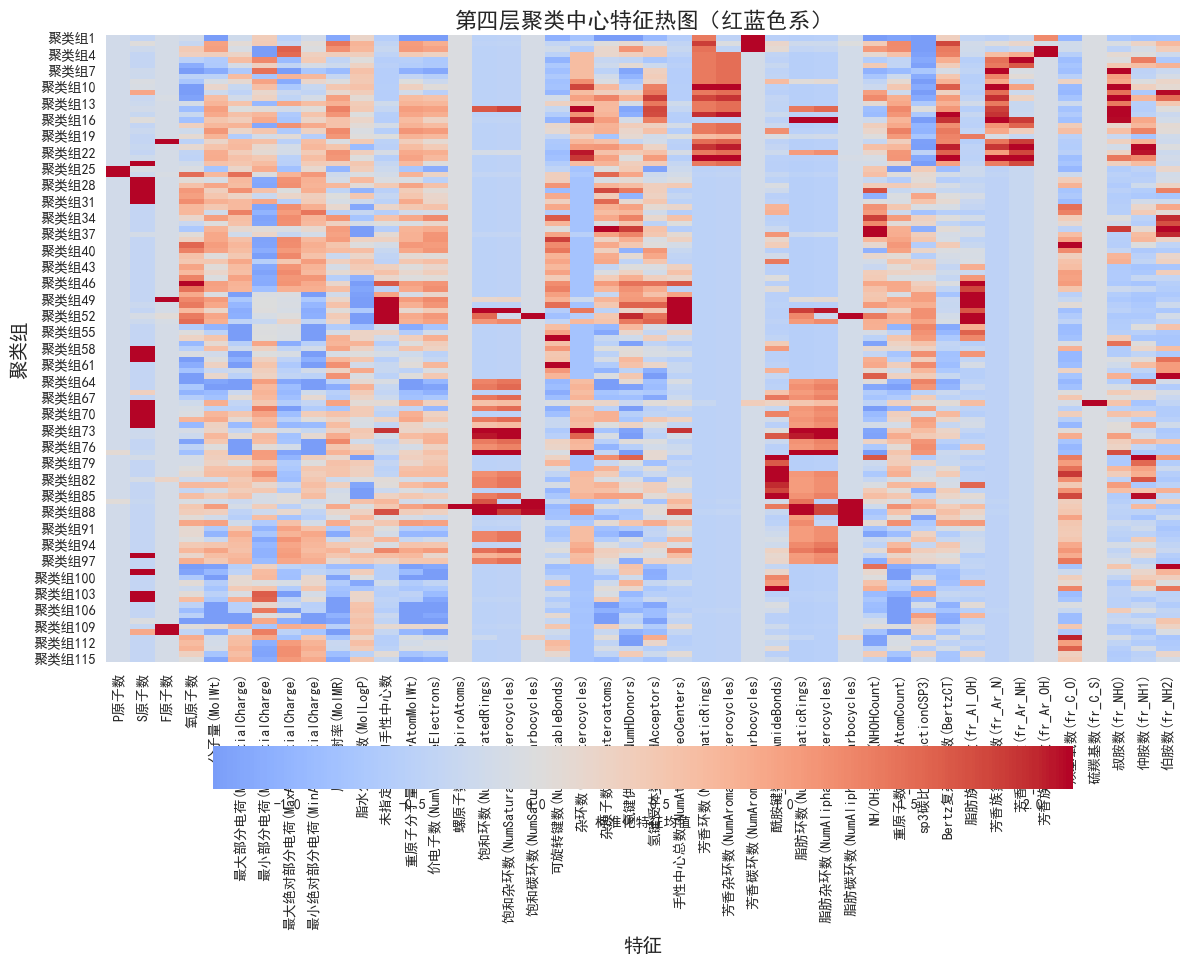

In [33]:
print("绘制红蓝色系的第四层聚类中心热图...")

# 计算每个聚类组的特征均值（中心）
cluster_centers = pd.DataFrame()
for cid in cluster_ids:
    cluster_samples = df_scaled[fourth_layer_labels == cid]
    cluster_centers[cluster_id_to_name[cid]] = cluster_samples.mean()

# 转置数据
cluster_centers = cluster_centers.T

# 绘制聚类中心热图
plt.figure(figsize=(12, 10))
sns.heatmap(
    cluster_centers,
    cmap='coolwarm',  # 经典红蓝色系
    center=0,  # 以0为中心
    robust=True,
    annot=False,  # 不显示数值
    cbar_kws={
        'label': '标准化特征均值',
        'orientation': 'horizontal',  # 色条在下方
        'pad': 0.1,
        'shrink': 0.8
    }
)

plt.title('第四层聚类中心特征热图（红蓝色系）', fontsize=16)
plt.xlabel('特征', fontsize=14)
plt.ylabel('聚类组', fontsize=14)

# 调整布局
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()

# 保存聚类中心热图
center_heatmap_path = os.path.join(output_dir, "第四层聚类中心热图（红蓝色系）.png")
plt.savefig(center_heatmap_path, dpi=300, bbox_inches='tight')
print(f"聚类中心热图已保存至: {center_heatmap_path}")
plt.show()




findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
C:\Users\zhang yanan\AppData\Local\Temp\ipykernel_5888\1748704981.py:43: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.tight_layout()
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' 

排除第87类后的PCA降维图像已保存至: 20250925\第四层聚类中心_PCA降维图（排除第87类）.png


<Figure size 1000x800 with 0 Axes>

findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: 

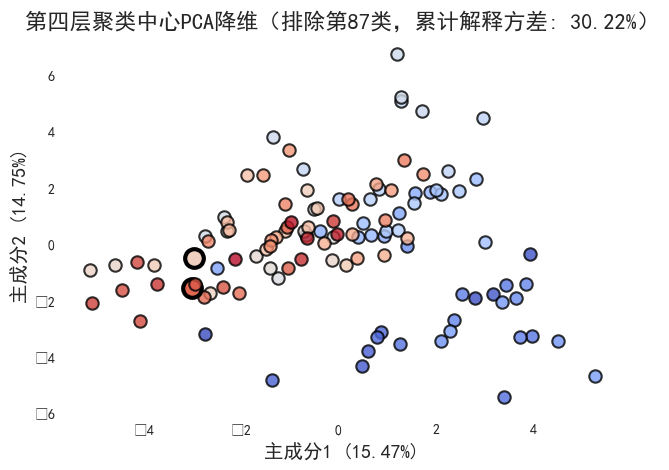

In [21]:
# 绘制PCA降维图像（突出显示第67和100类）
plt.figure(figsize=(10, 8))

# 设置中文字体
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
# 设置图表背景为白色
plt.figure(facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')  # 绘图区域背景色

# 绘制聚类中心散点
for i, cluster_name in enumerate(cluster_centers.index):
    # 提取聚类ID（从"聚类组X"中提取X）
    cluster_id = int(cluster_name.replace("聚类组", ""))

    # 设置普通点的样式
    size = 80  # 进一步减小普通点的大小
    linewidth = 1.5

    # 如果是第67或100类，设置突出显示的样式
    if cluster_id in [67, 100]:
        size = 180  # 增大点大小
        linewidth = 3  # 加粗边框
        alpha = 1.0  # 不透明
    else:
        alpha = 0.8  # 稍微透明

    plt.scatter(
        pca_results[i, 0],
        pca_results[i, 1],
        color=colors[i],
        s=size,
        alpha=alpha,
        edgecolors='black',
        linewidth=linewidth
    )

# 图表美化
plt.title(f'第四层聚类中心PCA降维（排除第87类，累计解释方差: {sum(explained_variance):.2%}）', fontsize=16)
plt.xlabel(f'主成分1 ({explained_variance[0]:.2%})', fontsize=14)
plt.ylabel(f'主成分2 ({explained_variance[1]:.2%})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# 保存图像（确保保存时背景为白色）
pca_plot_path = os.path.join(output_dir, "第四层聚类中心_PCA降维图（排除第87类）.png")
plt.savefig(pca_plot_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"排除第87类后的PCA降维图像已保存至: {pca_plot_path}")
plt.show()